In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers

2022-03-21 02:39:17.489819: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-21 02:39:17.490034: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data=yf.download('0700.hk')

[*********************100%***********************]  1 of 1 completed


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [16]:
data_val=data[-100:]
data=data[:-100]
data_val.tail()

,Open,High,Low,Close,Adj Close,Volume,6day MA,12day MA,RSI,%R5,%R10,MI6,MI12,EMA12,EMA26,MACD,TR,OSC6,OSC12,Prediction
Date,,,,,,,,,,,,,,,,,,,,
2021-10-18,499.399994,499.399994,485.399994,497.0,497.0,20730047,487.500000,472.883331,67.154353,-10.714286,-5.494505,50.600006,32.399994,478.541343,474.546379,3.994964,14.000000,37.743274,21.398044,499.0
2021-10-19,495.399994,500.000000,490.600006,499.0,499.0,15427765,492.100001,475.316666,68.287985,-5.050508,-1.831502,27.600006,29.200012,481.688829,476.357759,5.331070,9.399994,40.304470,22.871207,509.5
2021-10-20,508.000000,515.000000,504.500000,509.5,509.5,32724023,496.716670,479.024999,73.821964,-15.804603,-7.902298,27.700012,44.500000,485.967470,478.812739,7.154731,16.000000,52.591646,30.347746,505.5
2021-10-21,509.500000,512.500000,500.000000,505.5,505.5,16682945,498.300003,482.699999,68.508524,-31.045745,-13.688762,9.500000,44.100006,488.972475,480.789574,8.182901,12.500000,39.468490,25.300035,509.5
2021-10-22,507.500000,512.000000,502.500000,509.5,509.5,12743265,502.683334,487.074999,70.948085,-18.581077,-9.046054,26.299988,52.500000,492.130556,482.916272,9.214284,9.500000,45.131081,28.327854,505.0


In [17]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [18]:
X=sc.fit_transform(data.drop('Prediction',1))
Y = data["Prediction"].values.reshape(-1,1)
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(3741, 1, 19) (3741, 1) (416, 1, 19) (416, 1)


/tmp/ipykernel_23531/1768392262.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [33]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [34]:
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=300,
    batch_size=5,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)
y_pred = model_tech.predict(X_test)

Epoch 1/300
674/674 [==============================] - 6s 4ms/step - loss: 11655.5234 - val_loss: 714.0106
Epoch 2/300
674/674 [==============================] - 2s 3ms/step - loss: 324.7065 - val_loss: 94.2918
Epoch 3/300
674/674 [==============================] - 2s 3ms/step - loss: 113.8715 - val_loss: 69.4076
Epoch 4/300
674/674 [==============================] - 2s 3ms/step - loss: 74.9346 - val_loss: 64.8726
Epoch 5/300
674/674 [==============================] - 2s 3ms/step - loss: 60.0994 - val_loss: 59.7216
Epoch 6/300
674/674 [==============================] - 2s 3ms/step - loss: 51.8493 - val_loss: 52.2550
Epoch 7/300
674/674 [==============================] - 2s 3ms/step - loss: 46.6021 - val_loss: 45.7927
Epoch 8/300
674/674 [==============================] - 2s 3ms/step - loss: 43.2199 - val_loss: 41.3114
Epoch 9/300
674/674 [==============================] - 2s 3ms/step - loss: 41.0378 - val_loss: 38.7233
Epoch 10/300
674/674 [==============================] - 2s 3ms/step

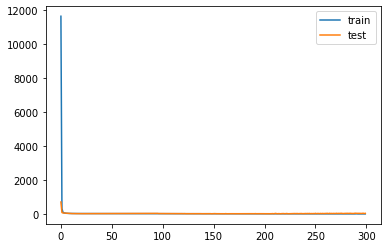

In [35]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

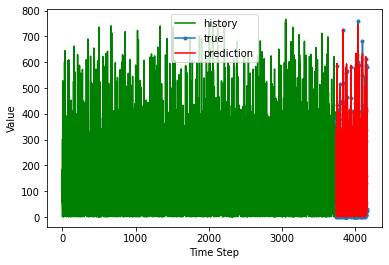

In [36]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

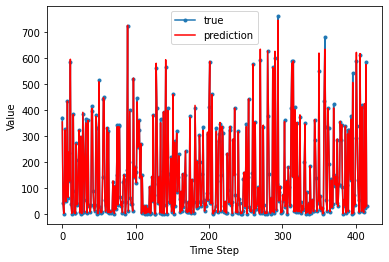

In [37]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [38]:
r2_score(y_test,y_pred)

0.9984210181489775

In [39]:
mean_absolute_percentage_error(y_test,y_pred)

0.0954118957858746

In [40]:
mean_squared_error(y_test,y_pred,squared=False)

6.74061421808549

In [41]:
x_val=data_val.drop('Prediction',1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/tmp/ipykernel_23531/2328949661.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1)


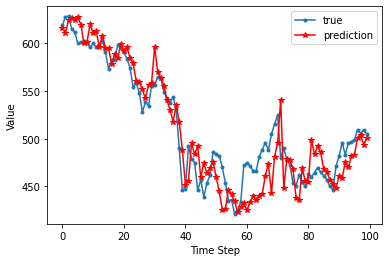

In [42]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [43]:
r2_score(y_val,y_val_pred)

0.8409592370680746

In [44]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.03590093248573355

In [45]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

22.993896133774456